In [ ]:
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split

In [ ]:
df1 = pd.read_csv('/content/2024_DS_Track_File1_kaustubhgupta.csv')
df2 = pd.read_csv('/content/2024_DS_Track_File2_kaustubhgupta.csv')

In [ ]:
df1.fillna(0, inplace=True)

In [ ]:
df1.isna().sum()

match id            0
dataset_type        0
win_pred_team_id    0
win_pred_score      0
indep_feat_id1      0
indep_feat_id2      0
indep_feat_id3      0
indep_feat_id4      0
indep_feat_id5      0
indep_feat_id6      0
indep_feat_id7      0
indep_feat_id8      0
indep_feat_id9      0
indep_feat_id10     0
train_algorithm     0
is_ensemble         0
train_hps_trees     0
train_hps_depth     0
train_hps_lr        0
dtype: int64

In [ ]:
df1.to_csv('output.csv', index=False)

In [ ]:
df = pd.read_csv('/content/output.csv')

In [ ]:
df.head(5)

,match id,dataset_type,win_pred_team_id,win_pred_score,indep_feat_id1,indep_feat_id2,indep_feat_id3,indep_feat_id4,indep_feat_id5,indep_feat_id6,indep_feat_id7,indep_feat_id8,indep_feat_id9,indep_feat_id10,train_algorithm,is_ensemble,train_hps_trees,train_hps_depth,train_hps_lr
0,9250275,r1,90,0.617014,0.563536,1.000000,1.220169,0.183333,1.149402,0.00,1.822677,1.112334,0.000000,0.000,XGBoost; CatBoost,yes,200;100,5;7,0.01;0.05
1,9262189,r1,36084,0.513995,0.910853,7.272727,1.091648,0.915709,1.058097,66.67,1.254352,1.229353,151.285714,153.500,XGBoost; CatBoost,yes,200;100,5;7,0.01;0.05
2,9128776,r1,48334,0.693042,0.957983,0.923077,0.955992,1.087500,0.942046,100.00,0.966169,1.085282,171.066667,179.625,XGBoost; CatBoost,yes,200;100,5;7,0.01;0.05
3,9586919,r1,36112,0.788017,0.527671,0.366667,0.771178,1.013774,0.978124,75.00,1.033636,0.758359,166.000000,155.500,XGBoost; CatBoost,yes,200;100,5;7,0.01;0.05
4,9128538,r1,48341,0.720495,0.284091,0.829630,1.166437,0.965577,1.039448,0.00,1.095952,1.123804,169.933333,164.125,XGBoost; CatBoost,yes,200;100,5;7,0.01;0.05


In [ ]:
train_data = pd.read_csv('/content/663e2b6d54457_train_data_with_samplefeatures.csv')
test_data = pd.read_csv('/content/6644a1e287df6_test_data_with_samplefeatures.csv')
batting_data = pd.read_csv('/content/663e2b548c98c_batsman_level_scorecard.csv')
bowling_data = pd.read_csv('/content/663e2b2c60743_bowler_level_scorecard.csv')
match_data = pd.read_csv('/content/664389efa0868_match_level_scorecard.csv')

In [ ]:
import numpy as np

def engineer_features_metrics(data, batting_data, bowling_data, match_data):
    # Calculate batting metrics
    batting_data['outs'] = batting_data['out_by_bowler'].notna().astype(int)
    batsman_metrics = batting_data.groupby('batsman_id').agg({
        'runs': 'sum',
        'balls_faced': 'sum',
        'outs': 'sum'
    }).reset_index()

    # Batting average: total runs / number of outs
    batsman_metrics['batting_average'] = batsman_metrics.apply(lambda row: row['runs'] / row['outs'] if row['outs'] > 0 else row['runs'], axis=1)
    # Strike rate: total runs / total balls * 100
    batsman_metrics['strike_rate'] = batsman_metrics.apply(lambda row: (row['runs'] / row['balls_faced']) * 100 if row['balls_faced'] > 0 else 0, axis=1)

    # Calculate bowling metrics
    bowler_metrics = bowling_data.groupby('bowler_id').agg({
        'wicket_count': 'sum',
        'runs': 'sum',
        'balls_bowled': 'sum'
    }).reset_index()

    # Bowling average: total runs conceded / total wickets
    bowler_metrics['bowling_average'] = bowler_metrics.apply(lambda row: row['runs'] / row['wicket_count'] if row['wicket_count'] > 0 else row['runs'], axis=1)
    # Economy rate: total runs conceded / total balls * 6
    bowler_metrics['economy_rate'] = bowler_metrics.apply(lambda row: (row['runs'] / row['balls_bowled']) * 6 if row['balls_bowled'] > 0 else 0, axis=1)

    # Function to extract player IDs from the roster string
    def extract_player_ids(roster_str):
        return [float(id) for id in roster_str.split(':') if id]

    # Apply the function to the roster columns
    data['team1_roster_ids'] = data['team1_roster_ids'].apply(extract_player_ids)
    data['team2_roster_ids'] = data['team2_roster_ids'].apply(extract_player_ids)

    # Function to calculate team metrics based on player IDs
    def calculate_team_metrics(player_ids, batsman_metrics, bowler_metrics):
        # Filter metrics for the given player IDs
        batsman_subset = batsman_metrics[batsman_metrics['batsman_id'].isin(player_ids)]
        bowler_subset = bowler_metrics[bowler_metrics['bowler_id'].isin(player_ids)]

        # Aggregate metrics
        team_batting_average = batsman_subset['batting_average'].mean() if not batsman_subset.empty else 0
        team_strike_rate = batsman_subset['strike_rate'].mean() if not batsman_subset.empty else 0
        team_bowling_average = bowler_subset['bowling_average'].mean() if not bowler_subset.empty else 0
        team_economy_rate = bowler_subset['economy_rate'].mean() if not bowler_subset.empty else 0

        return team_batting_average, team_strike_rate, team_bowling_average, team_economy_rate

    # Calculate metrics for each match
    team_metrics = data.apply(lambda row: calculate_team_metrics(row['team1_roster_ids'], batsman_metrics, bowler_metrics) +
                                          calculate_team_metrics(row['team2_roster_ids'], batsman_metrics, bowler_metrics), axis=1)

    # Add the calculated metrics to the DataFrame
    data['team1_batting_average'], data['team1_strike_rate'], data['team1_bowling_average'], data['team1_economy_rate'], \
    data['team2_batting_average'], data['team2_strike_rate'], data['team2_bowling_average'], data['team2_economy_rate'] = zip(*team_metrics)

    # Calculate ratios
    data['batting_average_ratio'] = data.apply(lambda row: row['team1_batting_average'] / row['team2_batting_average'] if row['team2_batting_average'] != 0 else 1, axis=1)
    data['strike_rate_ratio'] = data.apply(lambda row: row['team1_strike_rate'] / row['team2_strike_rate'] if row['team2_strike_rate'] != 0 else 1, axis=1)
    data['bowling_average_ratio'] = data.apply(lambda row: row['team2_bowling_average'] / row['team1_bowling_average'] if row['team1_bowling_average'] != 0 else 1, axis=1)
    data['economy_rate_ratio'] = data.apply(lambda row: row['team2_economy_rate'] / row['team1_economy_rate'] if row['team1_economy_rate'] != 0 else 1, axis=1)

    return data

In [ ]:

# Apply feature engineering to train data
train_data_engineered1 = engineer_features_metrics(train_data, batting_data, bowling_data, match_data)

# Apply feature engineering to test data
test_data_engineered1 = engineer_features_metrics(test_data, batting_data, bowling_data, match_data)

# Verify that both datasets have the same columns
print("Train columns:", train_data_engineered1.columns)
print("Test columns:", test_data_engineered1.columns)

# Check for any missing columns in test data
missing_columns = set(train_data_engineered1.columns) - set(test_data_engineered1.columns)
if missing_columns:
    print("Missing columns in test data:", missing_columns)
else:
    print("All columns are present in both train and test data.")

# Save the engineered datasets
train_data_engineered1.to_csv('train_data_engineered1.csv', index=False)
test_data_engineered1.to_csv('test_data_engineered1.csv', index=False)

Train columns: Index(['match id', 'team1', 'team1_id', 'team1_roster_ids', 'team2',
       'team2_id', 'team2_roster_ids', 'winner', 'winner_id', 'toss winner',
       'toss decision', 'venue', 'city', 'match_dt', 'lighting', 'series_name',
       'season', 'ground_id', 'team_count_50runs_last15', 'team_winp_last5',
       'team1only_avg_runs_last15', 'team1_winp_team2_last15',
       'ground_avg_runs_last15', 'team1_batting_average', 'team1_strike_rate',
       'team1_bowling_average', 'team1_economy_rate', 'team2_batting_average',
       'team2_strike_rate', 'team2_bowling_average', 'team2_economy_rate',
       'batting_average_ratio', 'strike_rate_ratio', 'bowling_average_ratio',
       'economy_rate_ratio'],
      dtype='object')
Test columns: Index(['match id', 'team1', 'team1_id', 'team1_roster_ids', 'team2',
       'team2_id', 'team2_roster_ids', 'toss winner', 'toss decision', 'venue',
       'city', 'match_dt', 'lighting', 'series_name', 'season', 'ground_id',
       'team_cou

In [ ]:
test_data_engineered1.shape

(271, 33)

In [ ]:
train_data_engineered1.shape

(948, 35)

In [ ]:
def engineer_features(data, batting_data, bowling_data, match_data):
    def str_to_list(s):
        try:
            return ast.literal_eval(s)
        except:
            return []
    def safe_divide(a, b, default=1.0):
        try:
            return a / b if b != 0 else default
        except:
            return default

    def pressure_handling(match_data, team_id, last_n_matches=20, close_match_threshold=20):
        team_matches = match_data[(match_data['team1_id'] == team_id) | (match_data['team2_id'] == team_id)].sort_values('match_dt').tail(last_n_matches)
        close_matches = team_matches[team_matches['win amount'] <= close_match_threshold]
        return close_matches[close_matches['winner_id'] == team_id].shape[0] / close_matches.shape[0] if close_matches.shape[0] > 0 else 0

    def form_consistency(match_data, team_id, last_n_matches=10):
        team_matches = match_data[(match_data['team1_id'] == team_id) | (match_data['team2_id'] == team_id)].sort_values('match_dt').tail(last_n_matches)
        team_scores = team_matches.apply(lambda row: row['inning1_runs'] if row['team1_id'] == team_id else row['inning2_runs'], axis=1)
        return 1 / (team_scores.std() / team_scores.mean()) if team_scores.mean() > 0 else 0

    def ground_performance_index(match_data, team_id, ground_id, last_n_matches=10):
        team_ground_matches = match_data[
            (((match_data['team1_id'] == team_id) | (match_data['team2_id'] == team_id)) &
             (match_data['ground_id'] == ground_id))
        ].sort_values('match_dt').tail(last_n_matches)

        if team_ground_matches.empty:
            return 0

        wins = team_ground_matches[team_ground_matches['winner_id'] == team_id].shape[0]
        win_ratio = wins / team_ground_matches.shape[0]

        runs_scored = []
        runs_conceded = []
        for _, match in team_ground_matches.iterrows():
            if match['team1_id'] == team_id:
                runs_scored.append(match['inning1_runs'])
                runs_conceded.append(match['inning2_runs'])
            else:
                runs_scored.append(match['inning2_runs'])
                runs_conceded.append(match['inning1_runs'])

        avg_runs_scored = np.mean(runs_scored) if runs_scored else 0
        avg_runs_conceded = np.mean(runs_conceded) if runs_conceded else 0

        run_rate_diff = (avg_runs_scored / 50) - (avg_runs_conceded / 50)

        index = (win_ratio * 0.5) + (run_rate_diff * 0.5)

        return index

    def calculate_player_experience(player_id, batting_data, bowling_data):
        batting_matches = batting_data[batting_data['batsman_id'] == player_id]['match id'].nunique()
        bowling_matches = bowling_data[bowling_data['bowler_id'] == player_id]['match id'].nunique()
        return max(batting_matches, bowling_matches)  # Use max in case a player is both batsman and bowler

    # Create a dictionary of player experiences
    player_experiences = {}
    for player_id in set(batting_data['batsman_id']) | set(bowling_data['bowler_id']):
        player_experiences[player_id] = calculate_player_experience(player_id, batting_data, bowling_data)

    # Function to calculate team experience
    def calculate_team_experience(roster_ids):
        return np.mean([player_experiences.get(player_id, 0) for player_id in roster_ids])

    # Calculate team experience for each match
    data['team1_experience'] = data['team1_roster_ids'].apply(lambda x: calculate_team_experience(x))
    data['team2_experience'] = data['team2_roster_ids'].apply(lambda x: calculate_team_experience(x))

    # Calculate the ratio of team experiences
    data['team_experience_ratio'] = data.apply(lambda row: row['team1_experience'] / row['team2_experience']
                                               if row['team2_experience'] != 0 else 1, axis=1)




    # Calculate ratios of features
    data['pressure_handling_ratio'] = data.apply(lambda row: safe_divide(
        pressure_handling(match_data, row['team1_id']),
        pressure_handling(match_data, row['team2_id'])
    ), axis=1)

    data['form_consistency_ratio'] = data.apply(lambda row: safe_divide(
        form_consistency(match_data, row['team1_id']),
        form_consistency(match_data, row['team2_id'])
    ), axis=1)

    data['ground_performance_ratio'] = data.apply(lambda row: safe_divide(
        ground_performance_index(match_data, row['team1_id'], row['ground_id']),
        ground_performance_index(match_data, row['team2_id'], row['ground_id'])
    ), axis=1)



    return data

In [ ]:

# Apply feature engineering to train data
train_data_engineered = engineer_features(train_data_engineered1, batting_data, bowling_data, match_data)

# Apply feature engineering to test data
test_data_engineered = engineer_features(test_data_engineered1, batting_data, bowling_data, match_data)

# Verify that both datasets have the same columns
print("Train columns:", train_data_engineered.columns)
print("Test columns:", test_data_engineered.columns)

# Check for any missing columns in test data
missing_columns = set(train_data_engineered.columns) - set(test_data_engineered.columns)
if missing_columns:
    print("Missing columns in test data:", missing_columns)
else:
    print("All columns are present in both train and test data.")

# Save the engineered datasets
train_data_engineered.to_csv('train_data_engineered.csv', index=False)
test_data_engineered.to_csv('test_data_engineered.csv', index=False)

Train columns: Index(['match id', 'team1', 'team1_id', 'team1_roster_ids', 'team2',
       'team2_id', 'team2_roster_ids', 'winner', 'winner_id', 'toss winner',
       'toss decision', 'venue', 'city', 'match_dt', 'lighting', 'series_name',
       'season', 'ground_id', 'team_count_50runs_last15', 'team_winp_last5',
       'team1only_avg_runs_last15', 'team1_winp_team2_last15',
       'ground_avg_runs_last15', 'team1_batting_average', 'team1_strike_rate',
       'team1_bowling_average', 'team1_economy_rate', 'team2_batting_average',
       'team2_strike_rate', 'team2_bowling_average', 'team2_economy_rate',
       'batting_average_ratio', 'strike_rate_ratio', 'bowling_average_ratio',
       'economy_rate_ratio', 'team1_experience', 'team2_experience',
       'team_experience_ratio', 'pressure_handling_ratio',
       'form_consistency_ratio', 'ground_performance_ratio'],
      dtype='object')
Test columns: Index(['match id', 'team1', 'team1_id', 'team1_roster_ids', 'team2',
       'team2

In [ ]:
test_data_engineered.shape


(271, 39)

In [ ]:
print("Train columns:", train_data_engineered.columns)

Train columns: Index(['match id', 'team1', 'team1_id', 'team1_roster_ids', 'team2',
       'team2_id', 'team2_roster_ids', 'winner', 'winner_id', 'toss winner',
       'toss decision', 'venue', 'city', 'match_dt', 'lighting', 'series_name',
       'season', 'ground_id', 'team_count_50runs_last15', 'team_winp_last5',
       'team1only_avg_runs_last15', 'team1_winp_team2_last15',
       'ground_avg_runs_last15', 'team1_batting_average', 'team1_strike_rate',
       'team1_bowling_average', 'team1_economy_rate', 'team2_batting_average',
       'team2_strike_rate', 'team2_bowling_average', 'team2_economy_rate',
       'batting_average_ratio', 'strike_rate_ratio', 'bowling_average_ratio',
       'economy_rate_ratio', 'team1_experience', 'team2_experience',
       'team_experience_ratio', 'pressure_handling_ratio',
       'form_consistency_ratio', 'ground_performance_ratio'],
      dtype='object')


In [ ]:
selected_data = train_data_engineered[['team1_experience', 'team2_experience', 'team_experience_ratio']]

In [ ]:
selected_data.head()

,team1_experience,team2_experience,team_experience_ratio
0,11.416667,4.500000,2.537037
1,71.363636,53.545455,1.332767
2,30.000000,50.363636,0.595668
3,40.636364,48.000000,0.846591
4,43.166667,52.272727,0.825797


In [ ]:
train_data_engineered['winner_01'] = train_data_engineered.apply(lambda x: 1 if (x['team2']==x['winner']) else 0, axis=1)
train_data_engineered['toss_winner_01'] = np.where(train_data_engineered['toss winner']==train_data_engineered['team2'], 1, 0)
test_data_engineered['toss_winner_01'] = np.where(test_data_engineered['toss winner']==test_data_engineered['team2'], 1, 0)

train_data_engineered['toss_decision_01'] = np.where(train_data_engineered['toss decision']=='bat', 1, 0)
test_data_engineered['toss_decision_01'] = np.where(test_data_engineered['toss decision']=='bat', 1, 0)

In [ ]:
print("Train columns:", train_data_engineered.columns)

Train columns: Index(['match id', 'team1', 'team1_id', 'team1_roster_ids', 'team2',
       'team2_id', 'team2_roster_ids', 'winner', 'winner_id', 'toss winner',
       'toss decision', 'venue', 'city', 'match_dt', 'lighting', 'series_name',
       'season', 'ground_id', 'team_count_50runs_last15', 'team_winp_last5',
       'team1only_avg_runs_last15', 'team1_winp_team2_last15',
       'ground_avg_runs_last15', 'team1_batting_average', 'team1_strike_rate',
       'team1_bowling_average', 'team1_economy_rate', 'team2_batting_average',
       'team2_strike_rate', 'team2_bowling_average', 'team2_economy_rate',
       'batting_average_ratio', 'strike_rate_ratio', 'bowling_average_ratio',
       'economy_rate_ratio', 'team1_experience', 'team2_experience',
       'team_experience_ratio', 'pressure_handling_ratio',
       'form_consistency_ratio', 'ground_performance_ratio', 'winner_01',
       'toss_winner_01', 'toss_decision_01'],
      dtype='object')


In [ ]:
feature_columns = [
        'toss_winner_01', 'toss_decision_01', 'team_count_50runs_last15',
        'team_winp_last5', 'team1only_avg_runs_last15', 'team1_winp_team2_last15',
        'ground_avg_runs_last15', 'batting_average_ratio', 'strike_rate_ratio',
        'bowling_average_ratio', 'economy_rate_ratio', 'pressure_handling_ratio',
        'form_consistency_ratio', 'ground_performance_ratio', 'team_experience_ratio'
    ]

In [ ]:
X = train_data_engineered[feature_columns]
y = train_data_engineered['winner_01']

In [ ]:
X_test_data = test_data_engineered[X.columns.tolist()]

In [ ]:
X_test_data.shape

(271, 15)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:

algo_name = 'GradientBoostingClassifier'
is_ensemble = 'no'
n_trees = 10
depth = 2
lr = 0.1

In [ ]:
pip install catboost

In [ ]:
X.head(5)

,toss_winner_01,toss_decision_01,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,team1_winp_team2_last15,ground_avg_runs_last15,batting_average_ratio,strike_rate_ratio,bowling_average_ratio,economy_rate_ratio,pressure_handling_ratio,form_consistency_ratio,ground_performance_ratio,team_experience_ratio
0,1,0,1.666667,0.672131,139.000000,100.0,157.178571,0.718598,1.119042,0.538833,1.058045,0.883929,0.680262,0.283133,2.537037
1,1,0,1.285714,1.952381,156.000000,50.0,103.500000,1.039404,0.966568,1.128354,1.064083,1.000000,1.131014,0.824818,1.332767
2,1,0,0.857143,0.672131,173.266667,0.0,154.333333,1.139969,0.909712,0.991083,1.034400,0.714286,0.720031,5.786517,0.595668
3,0,1,2.166667,1.975610,164.266667,50.0,144.250000,1.266137,1.052218,1.091221,0.993391,1.246753,2.698152,0.369863,0.846591
4,1,0,0.818182,1.327869,164.666667,0.0,189.000000,0.924754,1.127849,1.076982,1.000957,0.711111,1.633398,0.068627,0.825797


In [ ]:
import numpy as np
import pandas as pd

def clean_data(X, y):
    # Count initial NaN values
    initial_nan_count = X.isna().sum().sum()

    # Replace NaN values with the mean of each column
    X_clean = X.fillna(X.mean())

    # Count remaining NaN values (should be 0)
    remaining_nan_count = X_clean.isna().sum().sum()

    print(f"Replaced {initial_nan_count} NaN values with column means")
    print(f"Remaining NaN values: {remaining_nan_count}")

    return X_clean, y

# Use this function in your data preparation process
X_train_clean, y_train_clean = clean_data(X_train, y_train)
X_test_clean, y_test_clean = clean_data(X_test, y_test)

Replaced 64 NaN values with column means
Remaining NaN values: 0
Replaced 19 NaN values with column means
Remaining NaN values: 0


Ensemble Accuracy: 0.8000


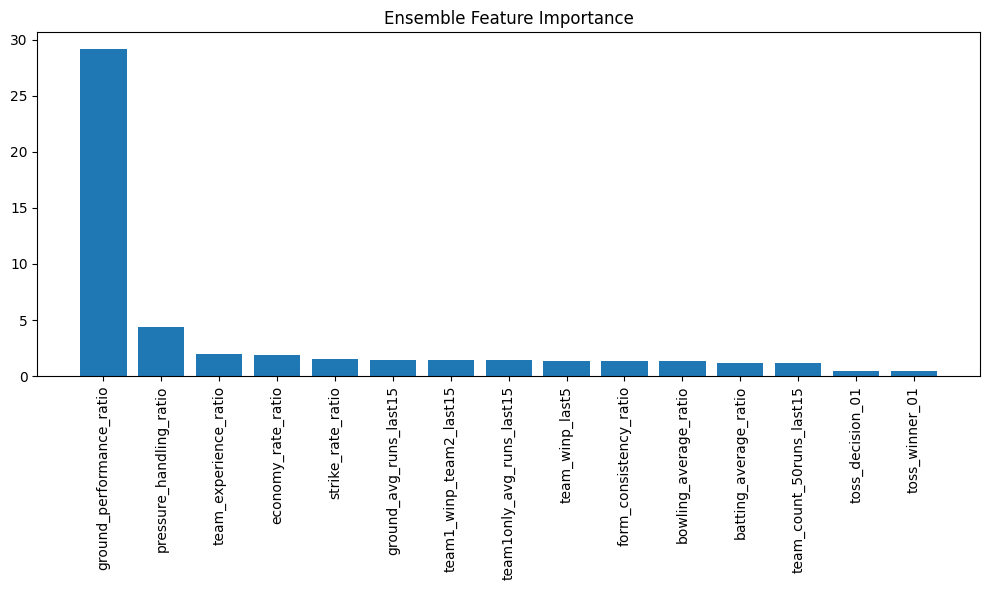


Best Hyperparameters:
XGBoost: {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
CatBoost: {'n_estimators': 100, 'learning_rate': 0.05, 'l2_leaf_reg': 7, 'depth': 7}

Top 10 Important Features for Ensemble Model:
                  feature  importance
 ground_performance_ratio   29.214291
  pressure_handling_ratio    4.347635
    team_experience_ratio    1.939692
       economy_rate_ratio    1.875123
        strike_rate_ratio    1.546490
   ground_avg_runs_last15    1.465369
  team1_winp_team2_last15    1.438931
team1only_avg_runs_last15    1.401133
          team_winp_last5    1.382948
   form_consistency_ratio    1.324672

Ensemble Model Accuracy: 0.8000


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

def train_and_evaluate(model, X_train, X_test, y_train, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    print(f"{model_name} Accuracy: {accuracy:.4f}")

    # Get feature importance
    if hasattr(model, 'feature_importances_'):
        feature_importance = model.feature_importances_
    else:
        # For VotingClassifier, average the feature importances of the base models
        feature_importance = np.mean(
            [clf.feature_importances_ for clf in model.estimators_ if hasattr(clf, 'feature_importances_')],
            axis=0
        )

    # Create a dataframe of feature importances
    feature_importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(feature_importance_df['feature'], feature_importance_df['importance'])
    plt.title(f"{model_name} Feature Importance")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    return accuracy, feature_importance_df

# Use the cleaned data
X_train, y_train = X_train_clean, y_train_clean
X_test, y_test = X_test_clean, y_test_clean


# Define the models
xgb = XGBClassifier(random_state=42,n_estimators=50,max_depth = 5,learning_rate = 0.05)
catboost = CatBoostClassifier(random_state=42, verbose=False)

xgb_random.fit(X_train, y_train)
catboost_random.fit(X_train, y_train)

# Best estimators and parameters
xgb_best = xgb_random.best_estimator_
catboost_best = catboost_random.best_estimator_

# Create an ensemble model
ensemble = VotingClassifier(estimators=[
    ('xgb', xgb_best),
    ('catboost', catboost_best)
], voting='soft')

# Train and evaluate the ensemble model
ensemble_accuracy, ensemble_importance = train_and_evaluate(ensemble, X_train, X_test, y_train, y_test, "Ensemble")

# Print best hyperparameters for each model
print("\nBest Hyperparameters:")
print(f"XGBoost: {xgb_random.best_params_}")
print(f"CatBoost: {catboost_random.best_params_}")

# Print top 10 important features for the ensemble model
print("\nTop 10 Important Features for Ensemble Model:")
print(ensemble_importance.head(10).to_string(index=False))

# Print the ensemble accuracy
print(f"\nEnsemble Model Accuracy: {ensemble_accuracy:.4f}")


In [ ]:
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Best hyperparameters for XGBoost and CatBoost
xgb_best_params = {
    'subsample': 0.6,
    'n_estimators': 200,
    'max_depth': 5,
    'learning_rate': 0.01,
    'colsample_bytree': 0.8,
    'random_state': 42
}

catboost_best_params = {
    'n_estimators': 100,
    'learning_rate': 0.05,
    'l2_leaf_reg': 7,
    'depth': 7,
    'random_state': 42,
    'verbose': False
}

# Create the models with the best hyperparameters
clf_xgb = XGBClassifier(**xgb_best_params)
clf_catboost = CatBoostClassifier(**catboost_best_params)

# Create an ensemble model
clf_ensemble = VotingClassifier(estimators=[
    ('xgb', clf_xgb),
    ('catboost', clf_catboost)
], voting='soft')

# Fit the ensemble model to the data
clf_ensemble.fit(X, y)

# Print model details
print("Ensemble model has been trained with the following classifiers:")
print(f"XGBoost: {clf_xgb}")
print(f"CatBoost: {clf_catboost}")


Ensemble model has been trained with the following classifiers:
XGBoost: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)
CatBoost: <catboost.core.CatBoostClassifier object at 0x7e9085a04a00>


In [ ]:
train_data['y_pred_01'] = clf_ensemble.predict(X)
test_data['y_pred_01'] = clf_ensemble.predict(X_test_data)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
# Train accuracy
print(classification_report(y, clf_ensemble.predict(X), labels=[0,1]))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85       468
           1       0.85      0.84      0.85       480

    accuracy                           0.85       948
   macro avg       0.85      0.85      0.85       948
weighted avg       0.85      0.85      0.85       948



In [ ]:
train_data['win_pred_score'] = clf_ensemble.predict_proba(X)[:,1]
test_data['win_pred_score'] = clf_ensemble.predict_proba(X_test_data)[:,1]

In [ ]:
train_data['win_pred_score'] = np.where( (train_data['y_pred_01']==0), (1-train_data['win_pred_score']), train_data['win_pred_score'])
test_data['win_pred_score'] = np.where( (test_data['y_pred_01']==0), (1-test_data['win_pred_score']), test_data['win_pred_score'])

In [ ]:
train_data['win_pred_team_id'] = np.where( (train_data['y_pred_01']==0), (train_data['team1_id']), train_data['team2_id'])
test_data['win_pred_team_id'] = np.where( (test_data['y_pred_01']==0), (test_data['team1_id']), test_data['team2_id'])

In [ ]:
feature_importances = np.mean(
    [clf.feature_importances_ for clf in clf_ensemble.estimators_ if hasattr(clf, 'feature_importances_')],
    axis=0
)

# Create a dataframe of feature importances
df_feat_importance = pd.DataFrame({
    'feat_name': X.columns.tolist(),
    'model_feat_imp_train': feature_importances
}).sort_values(by='model_feat_imp_train', ascending=False).reset_index(drop=True).head(10)


In [ ]:
df_feat_importance.head()

,feat_name,model_feat_imp_train,feat_id,feat_rank_train
0,ground_performance_ratio,30.047246,1,1
1,pressure_handling_ratio,3.774816,2,2
2,strike_rate_ratio,2.145270,3,3
3,team_experience_ratio,2.046044,4,4
4,economy_rate_ratio,1.732401,5,5


In [ ]:
train_data['dataset_type'] = 'train'
test_data['dataset_type'] = 'r1'

In [ ]:
df_file1 = pd.concat([test_data[['match id','dataset_type','win_pred_team_id','win_pred_score',] + list(df_feat_importance['feat_name'].head(10))], \
                     train_data[['match id','dataset_type','win_pred_team_id','win_pred_score',] + list(df_feat_importance['feat_name'].head(10))]])

renaming_dict = {}
for i,col in enumerate(list(df_feat_importance['feat_name'].head(10))):
    renaming_dict[col] = f'indep_feat_id{i+1}'
df_file1.rename(columns=renaming_dict, inplace=True)

for i in range(1,11):
    if f'indep_feat_id{i}' not in df_file1.columns:
        df_file1[f'indep_feat_id{i}'] = np.nan

df_file1['train_algorithm'] = 'XGBoost; CatBoost'
df_file1['is_ensemble'] = 'yes'
df_file1['train_hps_trees'] = '200;100'
df_file1['train_hps_depth'] = '5;7'
df_file1['train_hps_lr'] = '0.01;0.05'

In [ ]:
df_file1.shape
df_file1.head()

,match id,dataset_type,win_pred_team_id,win_pred_score,indep_feat_id1,indep_feat_id2,indep_feat_id3,indep_feat_id4,indep_feat_id5,indep_feat_id6,indep_feat_id7,indep_feat_id8,indep_feat_id9,indep_feat_id10,train_algorithm,is_ensemble,train_hps_trees,train_hps_depth,train_hps_lr
0,9250275,r1,90,0.617014,0.563536,1.000000,1.220169,0.183333,1.149402,0.00,1.822677,1.112334,NaN,NaN,XGBoost; CatBoost,yes,200;100,5;7,0.01;0.05
1,9262189,r1,36084,0.513995,0.910853,7.272727,1.091648,0.915709,1.058097,66.67,1.254352,1.229353,151.285714,153.500,XGBoost; CatBoost,yes,200;100,5;7,0.01;0.05
2,9128776,r1,48334,0.693042,0.957983,0.923077,0.955992,1.087500,0.942046,100.00,0.966169,1.085282,171.066667,179.625,XGBoost; CatBoost,yes,200;100,5;7,0.01;0.05
3,9586919,r1,36112,0.788017,0.527671,0.366667,0.771178,1.013774,0.978124,75.00,1.033636,0.758359,166.000000,155.500,XGBoost; CatBoost,yes,200;100,5;7,0.01;0.05
4,9128538,r1,48341,0.720495,0.284091,0.829630,1.166437,0.965577,1.039448,0.00,1.095952,1.123804,169.933333,164.125,XGBoost; CatBoost,yes,200;100,5;7,0.01;0.05


In [ ]:
feature_desc = {'ground_performance_ratio':'Ratio of performance of both the teams on a particular ground like how many matches won there and runs scores and conceeded  etc',\
               'pressure_handling_ratio':'Ratio of performance of both the teams in the close matches ',\
               'team_experience_ratio':'Ratio of teams average matches played by the players  ',\
               'economy_rate_ratio':'Ratio of the average economy rate of both the teams',\
               'strike_rate_ratio':'Ratio of the average strike rate of both the teams',\

               'ground_avg_runs_last15' : 'average runs scored in the ground in last 15 games',\
               'team1_winp_team2_last15' : 'Team1\'s win percentage against Team2 in last 15 games',\
               'team1only_avg_runs_last15' : 'team1\'s avg inning runs in last 15 games',\
               'bowling_average_ratio' : 'Ratio of bowling average of both the teams',\
               'batting_average_ratio' : 'Ratio of batting average of both the teams'}

In [ ]:
# df_feat_importance.rename(index={0:'feat_id'}, inplace=True)
df_file2 = df_feat_importance
df_file2['feat_id'] = [i+1 for i in df_file2.index]
df_file2['feat_rank_train'] = [i+1 for i in df_file2.index]
df_file2 = df_file2.set_index('feat_id')
df_file2['feat_description'] = df_file2['feat_name'].map(feature_desc)

In [ ]:
df_file2

,feat_name,model_feat_imp_train,feat_rank_train,feat_description
feat_id,,,,
1,ground_performance_ratio,30.047246,1,Ratio of performance of both the teams on a pa...
2,pressure_handling_ratio,3.774816,2,Ratio of performance of both the teams in the ...
3,strike_rate_ratio,2.145270,3,Ratio of the average strike rate of both the t...
4,team_experience_ratio,2.046044,4,Ratio of teams average matches played by the p...
5,economy_rate_ratio,1.732401,5,Ratio of the average economy rate of both the ...
6,team1_winp_team2_last15,1.538155,6,Team1's win percentage against Team2 in last 1...
7,bowling_average_ratio,1.393114,7,Ratio of bowling average of both the teams
8,batting_average_ratio,1.385196,8,Ratio of batting average of both the teams
9,team1only_avg_runs_last15,1.259832,9,team1's avg inning runs in last 15 games


In [ ]:
df_file1.to_csv('file1.csv', index=False)
df_file2.to_csv('file2.csv')

In [ ]:
file1 = pd.read_csv('file1.csv')
file2 = pd.read_csv('file2.csv')

In [ ]:
file1.tail(5)

,match id,dataset_type,win_pred_team_id,win_pred_score,indep_feat_id1,indep_feat_id2,indep_feat_id3,indep_feat_id4,indep_feat_id5,indep_feat_id6,indep_feat_id7,indep_feat_id8,indep_feat_id9,indep_feat_id10,train_algorithm,is_ensemble,train_hps_trees,train_hps_depth,train_hps_lr
1214,9128601,train,30414,0.759000,0.558548,0.857143,0.970805,1.078675,0.987971,66.67,0.966900,0.958840,147.333333,166.400000,XGBoost; CatBoost,yes,200;100,5;7,0.01;0.05
1215,9433241,train,9701,0.796983,-0.604396,0.489510,0.903682,0.411765,0.831072,0.00,0.821820,0.843478,167.400000,170.466667,XGBoost; CatBoost,yes,200;100,5;7,0.01;0.05
1216,9097227,train,23869,0.793729,0.611276,0.909091,1.113690,0.595652,0.994746,0.00,1.091458,1.015242,NaN,NaN,XGBoost; CatBoost,yes,200;100,5;7,0.01;0.05
1217,9516695,train,36014,0.772879,-0.207547,1.166667,0.784852,0.966203,1.003647,66.67,0.973291,0.770097,182.800000,133.375000,XGBoost; CatBoost,yes,200;100,5;7,0.01;0.05
1218,9433633,train,7727,0.677466,4.620253,1.875000,1.177542,3.361963,1.275298,100.00,1.351749,1.414002,167.333333,164.192308,XGBoost; CatBoost,yes,200;100,5;7,0.01;0.05


In [ ]:
file2.tail()

,feat_id,feat_name,model_feat_imp_train,feat_rank_train,feat_description
5,6,team1_winp_team2_last15,1.538155,6,Team1's win percentage against Team2 in last 1...
6,7,bowling_average_ratio,1.393114,7,Ratio of bowling average of both the teams
7,8,batting_average_ratio,1.385196,8,Ratio of batting average of both the teams
8,9,team1only_avg_runs_last15,1.259832,9,team1's avg inning runs in last 15 games
9,10,ground_avg_runs_last15,1.236983,10,average runs scored in the ground in last 15 g...
